# **Modelling Loan Defaults**

## Objectives

* Fit and evaluate a classification model to predict if a borrower will churn or not

## Inputs

* outputs/datasets/collection/LoanDefaultData.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

In [224]:
# Ignore FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Change working directory

We need to change the working directory from its current folder, where the notebook is stored, to its parent folder
* First we access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\kathr\\Nextcloud\\Dokumente\\Karriere\\Projekte\\vscode-projects\\PP5\\LoanGuard\\jupyter_notebooks'

* Then we want to make the parent of the current directory the new current directory
    * os.path.dirname() gets the parent directory
    * os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"You set a new current directory: {current_dir}")

You set a new current directory: c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard


---

# Step 1: Load Data

Load the data from the “collection” folder, since we want to design the pipeline to be able to handle the cleaning and engineering by itself.

In [448]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/LoanDefaultData.csv")

print(df.shape)
df.head(3)

(32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3


### Drop duplicates

In [449]:
df = df.drop_duplicates()
print(df.shape)

(32416, 12)


### Set target variable

In [405]:
target_var = "loan_status"

---

# Step 2: ML Pipeline with all features

1. First create ML Pipelines:
    * the first and second for cleaning and feature engineering 
    * the third for modelling using all available data to predict a borrowers's default. We won’t use this pipeline until a later stage in our notebook, but it’s good practice to create all your pipelines at the start of your notebook

2. Next, we split the data into train and test sets

3. After that, we can handle the target balance, by applying the first and second pipelines to the data then resampling the train set target

4. Once the data is ready, we fit the third pipeline we created using multiple algorithms while using their default hyperparameters, so we can find the algorithms that show the best fit for our data

5. Next, for these given algorithms, we do an extensive optimization search so we can find the best hyperparameters for these algorithms and can identify the best model

6. After that we’ll need to assess the best model's most relevant features from the second pipeline

7. And finally, we evaluate the pipeline using the best model on the train and test sets to check if it meets the requirements we set in our business case

## ML pipeline for Data Cleaning and Feature Engineering

Now we apply what we know from the previous feature engineering step.

In [ ]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder
from feature_engine.imputation import MeanMedianImputer
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt


def PipelineDataCleaningAndFeatureEngineeringPart1():
    pipeline_base = Pipeline([
        ("MedianImputer", MeanMedianImputer(imputation_method='median', variables=['person_emp_length', 'loan_int_rate'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', fold=5, tail='right', 
                                  variables=['person_age','person_income', 'person_emp_length',
                                             'loan_amnt', 'loan_int_rate', 'loan_percent_income',
                                             'cb_person_cred_hist_length'])),
        ('log_transform', vt.LogTransformer(variables=['person_age', 
                                                       'person_income', 
                                                       'cb_person_cred_hist_length'])),
        ('power_transform', vt.PowerTransformer(variables=['person_emp_length', 
                                                           'loan_amnt', 
                                                           'loan_percent_income'])),
        ("OrdinalEncoderArbitrary", OrdinalEncoder(encoding_method='arbitrary', 
                                                   variables=['person_home_ownership', 
                                                              'loan_intent', 
                                                              'cb_person_default_on_file'], 
                                                   unseen='encode'))
    ])

    return pipeline_base

PipelineDataCleaningAndFeatureEngineeringPart1()


Pipeline(steps=[('MeanMedianImputer',
                 MeanMedianImputer(variables=['person_emp_length',
                                              'loan_int_rate'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=5,
                            variables=['person_age', 'person_income',
                                       'person_emp_length', 'loan_amnt',
                                       'loan_int_rate', 'loan_percent_income',
                                       'cb_person_cred_hist_length'])),
                ('log_transform',
                 LogTransformer(variables=['person_age', 'person_income',
                                           'cb_person_cred_hist_length'])),
                ('power_transform',
                 PowerTransformer(variables=['person_emp_length', 'loan_amnt',
                                             'loan_percent_income'])),
                ('OrdinalEncoderArbitrary',
                 OrdinalEncoder(encoding_method='arbitrary', unseen='encode',
                                variables=['person_home_ownership',
                                           'loan_intent',
                                           'cb_person_default_on_file']))])

The categorical encoder for `loan_grade` has to be directly applied on the `loan_grade` column and therefore has to be applied seperately from the other feature engineering steps.

In [ ]:
def PipelineDataCleaningAndFeatureEngineeringPart2():
    pipeline_base = Pipeline([
        ("OrdinalEncoderOrdered", OrdinalEncoder(encoding_method='ordered', variables="loan_grade", unseen='encode'))
    ])

    return pipeline_base

PipelineDataCleaningAndFeatureEngineeringPart2()

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(variables=['Education']))])

After all the previous transformations we still need to apply SmartCorrelatedSelection

In [455]:
def PipelineDataCleaningAndFeatureEngineeringPart3():
    pipeline_base = Pipeline([
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance"))
    ])

    return pipeline_base

PipelineDataCleaningAndFeatureEngineeringPart3()

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [ ]:
#%pip install lightgbm, catboost

In [456]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
# --- Linear Models ---
from sklearn.linear_model import LogisticRegression, RidgeClassifier

# --- Tree-based Models ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# --- Boosting Methods ---
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base


## Split Train and Test Set

At this point,
we use all 17 features.

In [458]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target_var], axis=1),
    df[target_var],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(25932, 11) (25932,) (6484, 11) (6484,)


In [459]:
X_train.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
10594,25,35364,RENT,0.0,EDUCATION,A,10000,9.32,0.28,N,3
7088,22,60000,RENT,3.0,EDUCATION,A,7000,6.91,0.12,N,2
14601,26,45600,RENT,5.0,VENTURE,A,2000,NaN,0.04,N,3


## Handle Target Imbalance

From our previous analysis we know we have to handle target imbalance to improve performance.

### Preparation: Data Cleaning and Feature Engineering

First apply PipelineDataCleaningAndFeatureEngineeringPart1(), PipelineDataCleaningAndFeatureEngineeringPart2() and PipelineDataCleaningAndFeatureEngineeringPart3(), because for resampling, the data can’t contain missing values
or categorical values. 

In [460]:
pipeline_data_cleaning_feat_eng_part1 = PipelineDataCleaningAndFeatureEngineeringPart1()
X_train = pipeline_data_cleaning_feat_eng_part1.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng_part1.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25932, 11) (25932,) (6484, 11) (6484,)


In [462]:
pipeline_data_cleaning_feat_eng_part2 = PipelineDataCleaningAndFeatureEngineeringPart2()
X_train["loan_grade"] = pipeline_data_cleaning_feat_eng_part2.fit_transform(pd.DataFrame(X_train["loan_grade"]),y_train)
X_test["loan_grade"] = pipeline_data_cleaning_feat_eng_part2.transform(pd.DataFrame(X_test["loan_grade"]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25932, 11) (25932,) (6484, 11) (6484,)


In [463]:
pipeline_data_cleaning_feat_eng_part3 = PipelineDataCleaningAndFeatureEngineeringPart3()
X_train = pipeline_data_cleaning_feat_eng_part3.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng_part3.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25932, 8) (25932,) (6484, 8) (6484,)


After applying the data cleaning and feature engineering pipeline, the number of features decreased from 11 to 8, because of ``SmartCorrelatedSelection``.

#### Apply SMOTE

Check current Train Set Target distribution to confirm the target is currently imbalanced.

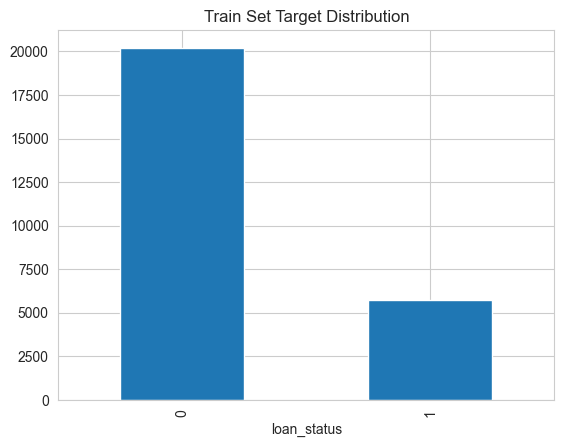

In [464]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE (Synthetic Minority Oversampling Technique) to balance the Train Set target.

In [465]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(40418, 8) (40418,) (6484, 8) (6484,)


Check Train Set Target distribution after resampling and confirm that the target is now balanced.

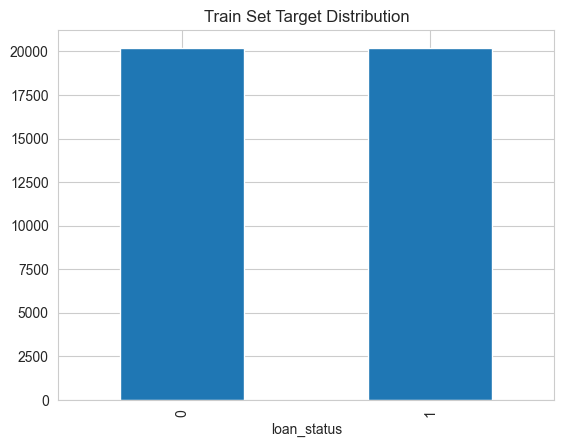

In [466]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn

This step is divided into 2 subsections:
* First, we will fit a set of pipelines for each algorithm using the default hyperparameters,
to find the algorithms that most suits the data
* Then, we will do an extensive hyperparameter search using these algorithms

This combined approach is faster than doing one extensive search on all algorithms at once.

### Custom Class for Hyperparameter Optimisation

We use the custom class introduced by Code Institute in the "Churnometer" walkthrough project, to help with hyperparameter optimization.

The class automates the hyperparameter tuning process across multiple models, each with its own parameter grid.

In the fit() method, each model is wrapped in a custom PipelineClf() and passed to GridSearchCV, which performs an exhaustive search over the defined hyperparameter combinations using cross-validation. The fitted grid search objects are stored for later analysis.

The score_summary() method then compiles the cross-validation results into a unified DataFrame, summarizing each model’s minimum, maximum, mean, and standard deviation of scores, enabling quick and consistent comparison across all tested algorithms.

In [ ]:
# Source: Code Institute, Churnometer Walkthrough Project
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, n_iter=30, randomized=False, verbose=1, scoring=None, refit=False):
        
        for key in self.keys:

            model = PipelineClf(self.models[key])
            params = self.params[key]
            if randomized == True:
                print(f"\nRunning RandomizedSearchCV for {key} \n")
                gs = RandomizedSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                                verbose=verbose, scoring=scoring, n_iter=n_iter)
            else: 
                print(f"\nRunning GridSearchCV for {key} \n")
                gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, 
                                  verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


### Use standard hyperparameters to find most suitable algorithms

#### Define algorithms for Quick Search

In [469]:
models_quick_search = {
    # Linear models
    "LogisticRegression": LogisticRegression(random_state=0),
    "RidgeClassifier": RidgeClassifier(random_state=0),

    #Tree-based models
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),

    # Boosting methods 
    "XGBClassifier": XGBClassifier(random_state=0),
    "LGBMClassifier": LGBMClassifier(random_state=0),
    "CatBoostClassifier": CatBoostClassifier(random_state=0, verbose=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0)
}

# Set empty dictionaries to indicated that we use the default hyperparameters
params_quick_search = {
    "LogisticRegression": {},
    "RidgeClassifier": {},
    "XGBClassifier": {},
    "LGBMClassifier": {},
    "CatBoostClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}


For our binary classification task, we selected a diverse set of models that cover different algorithmic families and learning principles. This allows us to compare performance across linear, tree-based, and ensemble approaches:

* Linear Models (Logistic Regression, Ridge Classifier):  
Serve as strong and interpretable baselines. They model linear relationships between features and the target and provide useful insights into feature importance.

* Tree-Based Models (Decision Tree, Random Forest, Extra Trees):  
Capture nonlinear relationships and feature interactions without requiring scaling or transformation. Random Forest and Extra Trees improve generalization by aggregating multiple decision trees.

* Boosting Methods (XGBoost, LightGBM, CatBoost, AdaBoost, Gradient Boosting):  
Build powerful ensembles by sequentially improving weak learners. These algorithms often achieve high accuracy on structured data and handle complex feature relationships effectively.

This model mix ensures a comprehensive benchmark, from simple and interpretable models to complex and high-performing ensemble methods, helping us identify the most suitable approach for our dataset.

#### Quick GridSearch CV

Next, we perform a quick GridSearchCV to evaluate the model performance of the different algorithms.

We set the scoring metric to Recall, as defined in our business case. This ensures the model prioritizes identifying potential defaulters correctly, minimizing the risk of classifying defaulting borrowers as non-defaulting. Recall is more appropriate than accuracy or precision here because misclassifying a defaulter as non-defaulter has a higher business cost than the opposite.


We use a hybrid score combining recall and F1 because the target is imbalanced and catching defaults is critical. This ensures the model prioritizes identifying true defaults (high recall) while still considering overall predictive quality (F1), guiding hyperparameter tuning toward a practical, business-relevant performance.



We also use 5-fold cross-validation to obtain a robust estimate of model performance and reduce the impact of random variation in the training data. It is a rule of thumb used in data science as a starting point.

In [472]:
from sklearn.metrics import make_scorer, recall_score, f1_score

def hybrid_score(y_true, y_pred):
    return 0.7 * recall_score(y_true, y_pred, pos_label=1) + 0.3 * f1_score(y_true, y_pred, average='macro')

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring = make_scorer(hybrid_score),
           n_jobs=-1, cv=5, verbose=2)


# search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
# search.fit(X_train, y_train,
#            scoring =  make_scorer(recall_score, pos_label=1), #recall score fits here as well
#            n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RidgeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for LGBMClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 20209, number of negative: 20209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bin

c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 20209, number of negative: 20209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 40418, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Running GridSearchCV for CatBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


#### Check results

In [473]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
6,LGBMClassifier,0.518895,0.852258,0.965801,0.172367
4,ExtraTreesClassifier,0.802971,0.849758,0.86342,0.023426
3,RandomForestClassifier,0.784036,0.847187,0.869415,0.032793
2,DecisionTreeClassifier,0.750702,0.831549,0.859673,0.041608
1,RidgeClassifier,0.756409,0.80844,0.832979,0.027197
0,LogisticRegression,0.743691,0.797929,0.820852,0.028015
9,GradientBoostingClassifier,0.617492,0.792094,0.856146,0.089239
7,CatBoostClassifier,0.102471,0.722107,0.965618,0.336969
5,XGBClassifier,0.1,0.649264,0.869458,0.301792
8,AdaBoostClassifier,0.140286,0.620017,0.778271,0.245742


* Among the tested algorithms, the best-performing model is the ``RandomForestClassifier``, achieving a mean Recall score of 0.85. The second-best model is the ``ExtraTreesClassifier``, with a Recall score of 0.84.

In a professional setting, we would continue tuning hyperparameters for both models, as their scores are both high and offer strong potential. However, to reduce computing time while still meeting the project requirements defined by Code Institute, we will focus only on the ``RandomForestClassifier`` for the next steps.


### Do an extensive search on the RandomForestClassifier to find the best hyperparameter configuration

Now we will perform an extensive grid search using the RandomForestClassifier to optimize its hyperparameters for the best possible performance.

#### Define algorithm and hyperparameter for Extensive Search

In [497]:
models_search = {
    "RandomForestClassifier":RandomForestClassifier(random_state=0)
}

# Documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://www.geeksforgeeks.org/machine-learning/hyperparameters-of-random-forest-classifier/

# params_search = {
#     "RandomForestClassifier":{
#         'model__n_estimators': [90, 100, 115, 130], 
#         'model__criterion': ["gini", "entropy", "log_loss"],
#         'model__max_depth': [10, 20, 30],
#         'model__min_samples_split': [2, 5, 10],
#         'model__min_samples_leaf': [1, 2, 4],
#         'model__max_features': [None, "log2", "sqrt"],
#         'model__class_weight': [None, 'balanced']
#     }
# }

# params_search = {
#     "RandomForestClassifier":{
#         'model__n_estimators': [100, 120], 
#         'model__criterion': ["gini", "entropy"],
#         'model__max_depth': [10, 20, 30],
#         'model__min_samples_split': [2, 5],
#         'model__min_samples_leaf': [1, 2],
#         'model__max_features': ["sqrt", "log2", None],
#         'model__class_weight': [None, 'balanced']
#     }
# }

# params_search = {
#     "RandomForestClassifier":{
#         'model__n_estimators': [500], 
#         'model__criterion': ["gini", "entropy", "log_loss"],
#         'model__max_depth': [5, 7, 10],
#         'model__min_samples_split': [5, 7, 10],
#         'model__min_samples_leaf': [3, 4, 5],
#         'model__max_samples': [0.5, 0.7, 1],
#         'model__max_features': ["log2", "sqrt"]
#     }

# good result 0.8 recall
# params_search = {
#     "RandomForestClassifier":{
#         'model__n_estimators': [300, 500, 800], 
#         'model__criterion': ["gini", "log_loss", "entropy"],
#         'model__max_depth': [5, 6, 7],
#         'model__min_samples_split': [5, 7, 10],
#         'model__min_samples_leaf': [3, 4, 5],
#         'model__max_features': ["log2", "sqrt", 0.5],
#         'model__class_weight': ['balanced', None]
#     }
    
params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [500, 800, 1000],  # add 1000 for potential small boost in stability
        'model__criterion': ["gini", "log_loss", "entropy"],      
        'model__max_depth': [6, 8, 10],           # extend range + None for full-depth test
        'model__min_samples_split': [2, 5, 10],         # include 2 (default) for potentially higher accuracy
        'model__min_samples_leaf': [1, 3, 5],           # include 1 to allow deeper splits on large data
        'model__max_features': ["sqrt", "log2", 0.5],   # keep both heuristic and float
        'model__class_weight': ['balanced', None]       # keep as is — useful for imbalance
    }

    
}

In [498]:
params_search

{'RandomForestClassifier': {'model__n_estimators': [500, 800, 1000],
  'model__criterion': ['gini', 'log_loss', 'entropy'],
  'model__max_depth': [6, 8, 10],
  'model__min_samples_split': [2, 5, 10],
  'model__min_samples_leaf': [1, 3, 5],
  'model__max_features': ['sqrt', 'log2', 0.5],
  'model__class_weight': ['balanced', None]}}

#### Extensive GridSearch CV

In [499]:
from sklearn.metrics import recall_score, make_scorer, f1_score
# search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
# search.fit(X_train, y_train,
#            scoring =  make_scorer(recall_score, pos_label=1),
#            n_jobs=-2, cv=5, verbose=3)

def hybrid_score(y_true, y_pred):
    return 0.7 * recall_score(y_true, y_pred, pos_label=1) + 0.3 * f1_score(y_true, y_pred, average='macro')

search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(hybrid_score), #recall score fits here as well
           n_jobs=-1, cv=5, verbose=2, randomized=True, n_iter=50)
# search.fit(X_train, y_train,
#            scoring = make_scorer(hybrid_score), #recall score fits here as well
#            n_jobs=-1, cv=5, verbose=2)


Running RandomizedSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


#### Check results

In [500]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head()

,estimator,min_score,mean_score,max_score,std_score,model__n_estimators,model__min_samples_split,model__min_samples_leaf,model__max_features,model__max_depth,model__criterion,model__class_weight
20,RandomForestClassifier,0.786005,0.807233,0.820125,0.011687,800,5,1,log2,6,gini,balanced
29,RandomForestClassifier,0.786958,0.807218,0.820717,0.011563,1000,5,5,0.5,6,gini,balanced
36,RandomForestClassifier,0.784884,0.807196,0.820717,0.01237,1000,2,1,sqrt,6,gini,balanced
42,RandomForestClassifier,0.786674,0.807048,0.819779,0.011514,800,2,3,0.5,6,gini,balanced
48,RandomForestClassifier,0.786105,0.807016,0.821655,0.012175,500,5,5,sqrt,6,gini,balanced


Get best model name programmatically

In [490]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

In [441]:
grid_search_pipelines

{'RandomForestClassifier': RandomizedSearchCV(cv=5,
                    estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('feat_selection',
                                               SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                                              ('model',
                                               RandomForestClassifier(random_state=0))]),
                    n_iter=50, n_jobs=-1,
                    param_distributions={'model__class_weight': ['balanced',
                                                                 None],
                                         'model__criterion': ['gini', 'log_loss',
                                                              'entropy'],
                                         'model__max_depth': [5, 6, 7],
                                         'model__max_features': ['log2', 'sqrt',
                                              

The best RandomForestClassifier model has a mean Recall of xx and the following hyperparameters:

In [501]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters
# good result recall 0.8
# {'model__n_estimators': 500,
#  'model__min_samples_split': 5,
#  'model__min_samples_leaf': 5,
#  'model__max_features': 'sqrt',
#  'model__max_depth': 5,
#  'model__criterion': 'gini',
#  'model__class_weight': 'balanced'}

{'model__n_estimators': 800,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 1,
 'model__max_features': 'log2',
 'model__max_depth': 6,
 'model__criterion': 'gini',
 'model__class_weight': 'balanced'}

Extract the best classification pipeline from the GridSearchCV object, which includes the preprocessing steps and the model fitted with the optimal hyperparameters found during the grid search.

In [502]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=6,
                                        max_features='log2',
                                        min_samples_split=5, n_estimators=800,
                                        random_state=0))])

## Assess feature importance

* With the current model, we can assess with `.features_importances_`

Our classification pipeline consists of three steps:

1. Feature scaling – standardizes the numerical variables.
2. Feature selection – selects the most relevant features for the model.
3. Modelling – fits the RandomForestClassifier on the selected features.

We can extract two pieces of information from the pipeline:

* Selected features: which features passed through the feature selection step and are actually used by the model.
* Feature importance: the importance scores of these features as calculated by the Random Forest in the modelling step.

In [503]:
selected_features = X_train.columns[pipeline_clf['feat_selection'].get_support()]
print(f"Number of selected features: {len(selected_features)}")
selected_features


Number of selected features: 3


Index(['person_income', 'loan_amnt', 'loan_int_rate'], dtype='object')

In [494]:
pipeline_clf['model'].feature_importances_

array([0.43542868, 0.21176088, 0.35281044])

We create a DataFrame that contains these features' importance and plot it as a bar plot, to show the most important features for the model.

* These are the 3 most important features in descending order. The model was trained on them: 
['person_income', 'loan_int_rate', 'loan_amnt']


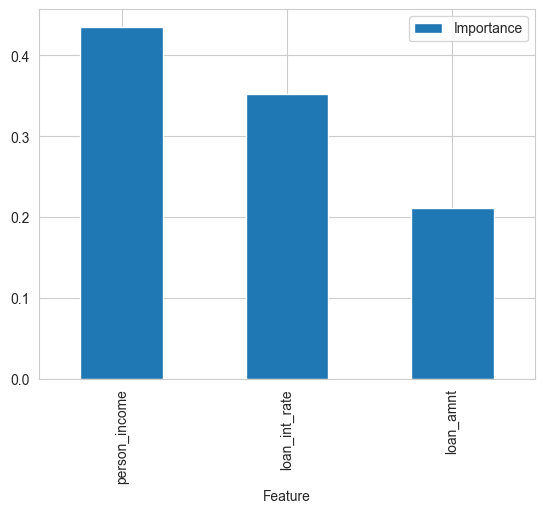

In [495]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


We note that from all 22 features we obtained after feature engineering, only 10 are relevant to
predict default. 

* The most important feature is LoanTerm, meaning that the duration of the loan has the strongest influence on the model’s predictions.
* All other numerical variables also show substantial predictive power
* From the categorical features only "HasCoSigner" and "EmploymentType" contribute to the predictions

Overall, numerical features dominate the model’s decision-making, while selected categorical indicators have a smaller but meaningful effect. This aligns with our earlier correlation and bivariate analyses, where numerical variables showed stronger relationships with the target than most categorical variables. This also confirms the low overall correlation values observed previously, where no single variable strongly explained loan default. Instead, default behavior is likely influenced by a combination of factors.

## Evaluate Pipeline on Train and Test Sets

In [484]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=y, y_pred=prediction),
          columns=[["Prediction " + sub for sub in label_map]],
          index=[["Actual " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


Evaluation: We cross check with metrics defined at ML business case
* 80% Recall for Churn, on train and test set
* 80% Precision for no Churn on train and test set. 

In [504]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Default', 'Default'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                  Prediction No Default Prediction Default
Actual No Default                 15864               4345
Actual Default                     3677              16532


---  Classification Report  ---
              precision    recall  f1-score   support

  No Default       0.81      0.78      0.80     20209
     Default       0.79      0.82      0.80     20209

    accuracy                           0.80     40418
   macro avg       0.80      0.80      0.80     40418
weighted avg       0.80      0.80      0.80     40418
 

#### Test Set ####

---  Confusion Matrix  ---
                  Prediction No Default Prediction Default
Actual No Default                  3977               1141
Actual Default                      280               1086


---  Classification Report  ---
              precision    recall  f1-score   support

  No Default       0.93      0.78      0.85      5118
     Default       0.49      0.80      0.60 

The recall on churn, and precision on no churn, are higher than 80% and therefore fulfill the business requirements.

We also note that the performance on the train and test set are not much different,
which is a good indicator that the model didn't overfit.

# Step 3: Refit pipeline with best features

We created a pipeline that needs 17 features, and over the steps, it selected
2 features to hit the model. 

For research purposes, this is fine. But for a real system,
we should have a pipeline using only two features. 

That is why we
will refit the pipeline, using the same steps and hyperparameters, but now using only two variables.

## Refit ML Pipeline and Resampling

In theory, a pipeline fitted **using only the most important features** should give the same result as the one fitted with **all variables and feature selection**

* However, in this project we have a step for feature augmentation, which is to balance the target Train Set using SMOTE(). As a result, the Train Set
after resampling will be slightly different, which again means the performance will be slightly different.
We should expect this. But we don’t expect is to have a big difference.


## Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [505]:
best_features

['person_income', 'loan_int_rate', 'loan_amnt']

New Pipeline for DataCleaning And FeatureEngineering with only the best features

In [506]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("MedianImputer", MeanMedianImputer(imputation_method='median', variables=['loan_int_rate'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', fold=5, tail='right', 
                                  variables=['person_income', 'loan_amnt', 'loan_int_rate'])),
        ('log_transform', vt.LogTransformer(variables=['person_income',])),
        ('power_transform', vt.PowerTransformer(variables=['loan_amnt']))
    ])

    return pipeline_base

## Rewrite ML Pipeline for Modelling

Function for Pipeline optmisation

In [507]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base


## Split Train Test Set, considering only with best features

In [516]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target_var], axis=1),
    df[target_var],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(25932, 11) (25932,) (6484, 11) (6484,)


We filter only the most important variables

In [517]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(25932, 3) (25932,) (6484, 3) (6484,)


,person_income,loan_int_rate,loan_amnt
10594,35364,9.32,10000
7088,60000,6.91,7000
14601,45600,NaN,2000


## Handle Target Imbalance

In [518]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25932, 3) (25932,) (6484, 3) (6484,)


Check Train Set Target distribution

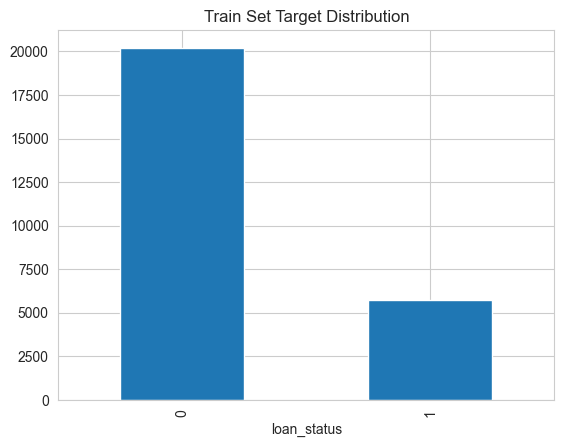

In [511]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE to balance Train Set target

In [519]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(40418, 3) (40418,) (6484, 3) (6484,)


Check Train Set Target distribution after SMOTE

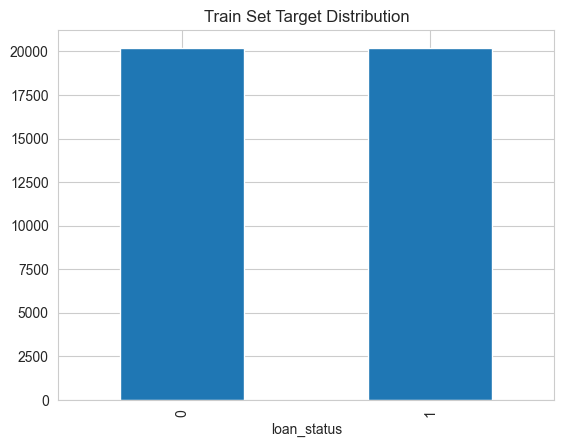

In [513]:
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()

## Grid Search CV: Sklearn

Using the most suitable model from the last section and its best hyperparameter configuration.

We are using the same model from  the last GridCV search

In [528]:
models_search   # XGBClassifier

{'RandomForestClassifier': RandomForestClassifier(random_state=0)}

And the best parameters from the last GridCV search 

In [ ]:
best_parameters

{'model__n_estimators': 800,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 1,
 'model__max_features': 'log2',
 'model__max_depth': 6,
 'model__criterion': 'gini',
 'model__class_weight': 'balanced'}

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [529]:
params_search = {'RandomForestClassifier':  {
    'model__n_estimators': [800],
    'model__min_samples_split': [5],
    'model__min_samples_leaf': [1],
    'model__max_features': ['log2'],
    'model__max_depth': [6],
    'model__criterion': ['gini'],
    'model__class_weight': ['balanced']
    }
}
params_search


{'RandomForestClassifier': {'model__n_estimators': [800],
  'model__min_samples_split': [5],
  'model__min_samples_leaf': [1],
  'model__max_features': ['log2'],
  'model__max_depth': [6],
  'model__criterion': ['gini'],
  'model__class_weight': ['balanced']}}

GridSearch CV

In [531]:
from sklearn.metrics import recall_score, make_scorer

def hybrid_score(y_true, y_pred):
    return 0.7 * recall_score(y_true, y_pred, pos_label=1) + 0.3 * f1_score(y_true, y_pred, average='macro')

quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
           scoring = make_scorer(hybrid_score),
           n_jobs=-1, cv=5, verbose=2)



Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

The summary performance is 0.89, slightly different from the previous which was 0.92.
that's because this time, the resampling was done using two features and before used all the variables available.

That means the train set is slightly different after resampling with a
slight difference in the pipeline performance, so we are happy to keep it as our best ML pipeline.

In [532]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__class_weight,model__criterion,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,RandomForestClassifier,0.780921,0.797934,0.811687,0.011339,balanced,gini,6,log2,1,5,800


Define the best clf pipeline

In [533]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=6,
                                        max_features='log2',
                                        min_samples_split=5, n_estimators=800,
                                        random_state=0))])

## Assess feature importance

* These are the 3 most important features in descending order. The model was trained on them: 
['person_income', 'loan_int_rate', 'loan_amnt']


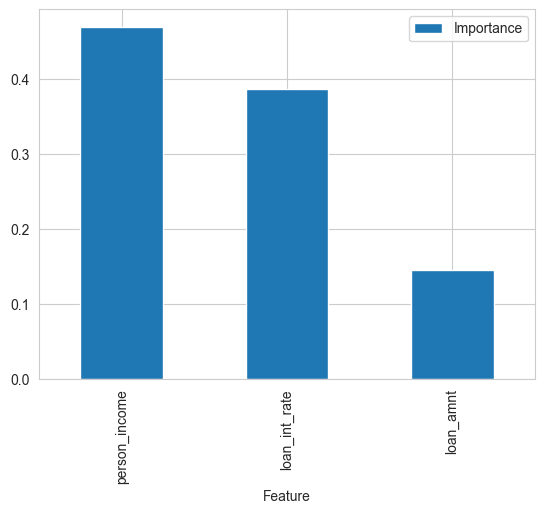

In [534]:

# We don't have feature selection,
# so the best features are the columns from the train set.
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


contracts and internet service have the same relevance as before

## Evaluate Pipeline on Train and Test Sets

Evaluation: We cross check with metrics defined at ML business case
* 80% Recall for Churn, on train and test set
* 80% Precision for no Churn on train and test set. 

In [536]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Default', 'Default'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                      Actual No Default Actual Default
Prediction No Default             16301           3995
Prediction Default                 3908          16214


---  Classification Report  ---
              precision    recall  f1-score   support

  No Default       0.80      0.81      0.80     20209
     Default       0.81      0.80      0.80     20209

    accuracy                           0.80     40418
   macro avg       0.80      0.80      0.80     40418
weighted avg       0.80      0.80      0.80     40418
 

#### Test Set ####

---  Confusion Matrix  ---
                      Actual No Default Actual Default
Prediction No Default              4084            302
Prediction Default                 1034           1064


---  Classification Report  ---
              precision    recall  f1-score   support

  No Default       0.93      0.80      0.86      5118
     Default       0.51      0.78      0.61      1366

    accuracy 

The recall on churn, and precision on no churn, are higher than 80% and therefore fulfill the business requirements.

We also note that the performance on the train and test set are not much different,
which is a good indicator that the model didn't overfit.

# Step 4: Push files to Repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [537]:
import joblib
import os

# First, we set a version tag, which will be the folder name. It's appropriate since it's a form
# of version control.
version = 'v1'
file_path = f'outputs/ml_pipeline/predict_default/{version}'

# create a folder to store the files.
try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Train Set

We will save the train and test set since we need them to evaluate the model in the dashboard.

We start with the train set. Note the data cleaning and feature engineering
pipeline have transformed the features. We see that the data is not categorical but numbers.

* note that the variables **are transformed already** in X_train and the shape is 8266 - after SMOTE was applied.

In [538]:
print(X_train.shape)
X_train.head()

(40418, 3)


,person_income,loan_int_rate,loan_amnt
0,10.473450,9.32,100.000000
1,11.002100,6.91,83.666003
2,10.727663,10.99,44.721360
3,11.849398,7.88,109.544512
4,9.852194,7.88,59.160798


In [539]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [540]:
y_train

0        0
1        0
2        0
3        0
4        1
        ..
40413    1
40414    1
40415    1
40416    1
40417    1
Name: loan_status, Length: 40418, dtype: int64

In [541]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

* note that the variables are transformed already in X_test

In [542]:
print(X_test.shape)
X_test.head()

(6484, 3)


,person_income,loan_int_rate,loan_amnt
21641,10.819778,13.49,77.459667
74,11.350407,7.49,167.332005
416,11.034954,7.90,154.919334
9369,11.025816,10.99,50.000000
6814,11.082143,10.99,77.459667


In [543]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [544]:
y_test

21641    0
74       1
416      1
9369     0
6814     0
        ..
29306    1
21414    0
7349     0
21283    0
12696    0
Name: loan_status, Length: 6484, dtype: int64

In [545]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines: 
* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.



Pipeline responsible for Data Cleaning and Feature Engineering.


In [546]:
pipeline_data_cleaning_feat_eng

Pipeline(steps=[('MedianImputer',
                 MeanMedianImputer(variables=['loan_int_rate'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=5,
                            variables=['person_income', 'loan_amnt',
                                       'loan_int_rate'])),
                ('log_transform', LogTransformer(variables=['person_income'])),
                ('power_transform', PowerTransformer(variables=['loan_amnt']))])

In [547]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

['outputs/ml_pipeline/predict_default/v1/clf_pipeline_data_cleaning_feat_eng.pkl']

* Pipeline responsible for Feature Scaling, and Model

In [548]:
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=6,
                                        max_features='log2',
                                        min_samples_split=5, n_estimators=800,
                                        random_state=0))])

In [549]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_default/v1/clf_pipeline_model.pkl']

## Feature Importance plot

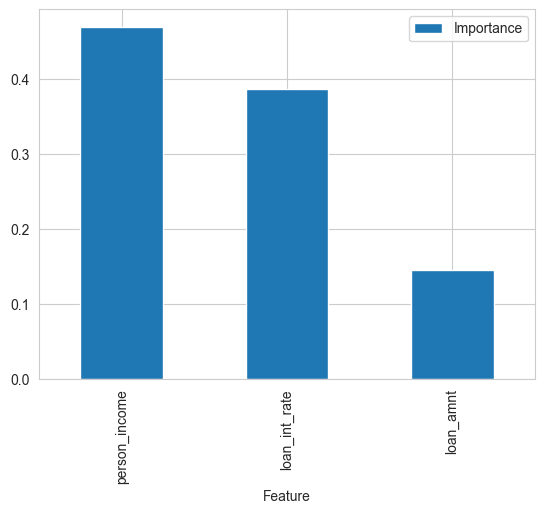

In [550]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

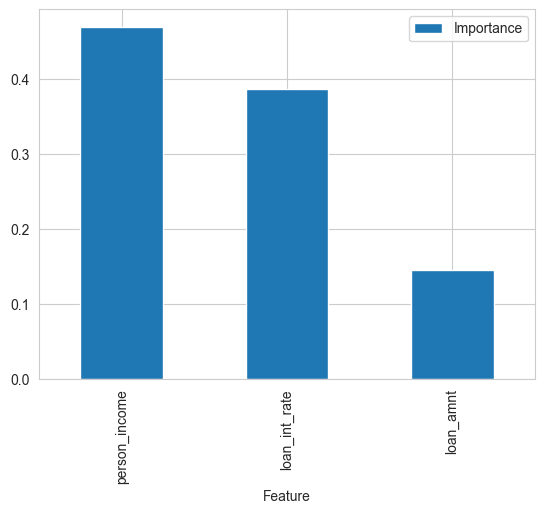

In [551]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job, you should clear outputs, then run git commands to push files to the repo. Next, move on to Predict Tenure notebook

---

# Conclusions and Next Steps

* Fill in conclusions and next steps